# 将数据转成PNG图片

嫦娥公开数据中有相当一部分是相机拍的月面照片。

In [1]:
# 需要安装的包
!pip install pillow numpy opencv-python pds4-tools planetaryimage colour-demosaicing colour-science scikit-image -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 63 kB 2.6 MB/s  eta 0:00:01


## 1. 解析pds数据

这一部分主要参考了[用Python打开嫦娥玉兔的科学数据](http://siyu.china-vo.org/2020/02/11/MakingOfCE4Image/)。

PCAM是全景相机，解析的步骤大致如下：

1. `pds4_tools.read()`读入数据
2. 将读入数据转成numpy数组
3. 归一化
4. de-bayer上色
5. 直方图拉伸
6. 保存到图片

估计能解析成图片的还有 __TCAM地貌相机__ 和 __LCAM着陆相机__。

In [2]:
def plot_img_and_hist(image, hist=True, bins=128):
    """Plot an image along with its histogram.
    """
    if hist:
        fig, axes = plt.subplots(2,1, figsize=(10,10), gridspec_kw={'height_ratios': [3, 1]})
        ax_img, ax_hist = axes
    else:
        fig, ax_img = plt.subplots(figsize=(10,10))

    # Display image
    ax_img.imshow(image, cmap='gray')
    ax_img.set_axis_off()

    if hist:
        # Display histogram
        ax_hist.hist(image[:,:,0].ravel(), bins=bins, histtype='step', color='red')
        ax_hist.hist(image[:,:,1].ravel(), bins=bins, histtype='step', color='green')
        ax_hist.hist(image[:,:,2].ravel(), bins=bins, histtype='step', color='blue')

        ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
        ax_hist.set_xlabel('Pixel intensity')
        ax_hist.set_xlim(0, 1)
        ax_hist.set_yticks([])

In [1]:
from PIL import Image
import matplotlib.pyplot as plt        # for plotting
import matplotlib
import numpy as np
import pds4_tools
import colour
import colour_demosaicing
from skimage import exposure

img = {}

filename = 'data/CE4_GRAS_PCAML-C-001_SCI_N_20190104041637_20190104041637_0001_B.2BL'

# 读入嫦娥4号2BL数据
img['pds_data'] = pds4_tools.read(filename)

Processing label: data/CE4_GRAS_PCAML-C-001_SCI_N_20190104041637_20190104041637_0001_B.2BL
Now processing a Array_2D_Image structure: ARRAY_0


In [47]:
# 将图像数据提取出来
img['raw_data'] = np.asanyarray(img['pds_data'][0].data)
print(img['raw_data'].shape, img['raw_data'].ndim)
img['raw_data'] = img['raw_data'] / 1023      #10位的图像数据归一化 
# 保存数据到图片
p = img['raw_data'] * 255
p = p.astype('uint8')
img['pil'] = Image.fromarray(p)
img['pil'].save(filename.replace('data', 'png') + '_0.png')

(1728, 2352) 2


(1728, 2352, 3) 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


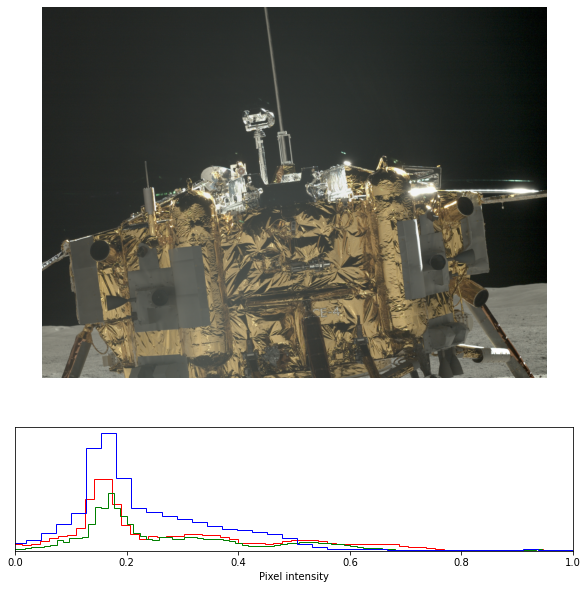

In [49]:
# de-bayer
# colour_demosaicing库中提供了三种CFA（彩色滤光片阵列）的上色方法，分别是bilinear、Malvar2004、Menon2007，据说Menon2007的边缘效果更好一些
rgb_data = colour.cctf_encoding(colour_demosaicing.demosaicing_CFA_Bayer_bilinear(img['raw_data'], 'RGGB')) 
#rgb_data = colour.cctf_encoding(colour_demosaicing.demosaicing_CFA_Bayer_Menon2007(img['raw_data'], 'RGGB')) 
print(rgb_data.shape, rgb_data.ndim)
img['rgb_data'] = rgb_data
p = img['rgb_data'] * 255
p = p.astype('uint8')
img['pil'] = Image.fromarray(p)
img['pil'].save(filename.replace('data', 'png') + '_1.png')
plot_img_and_hist(img['rgb_data'])

0.11049941568 0.722783430948


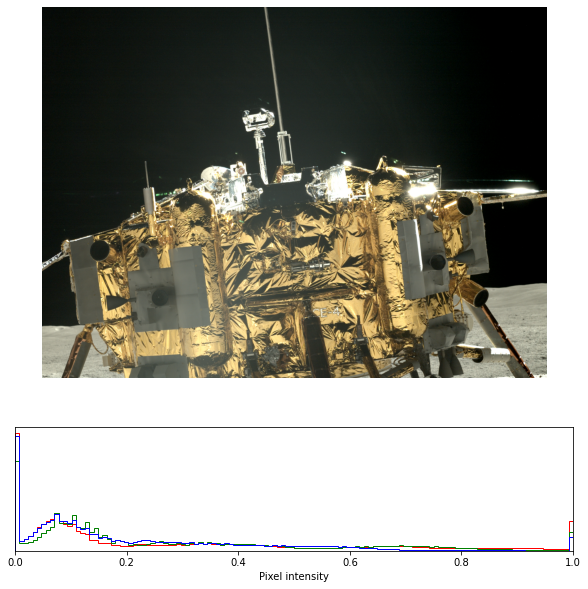

In [50]:
# 直方图拉伸
lower, upper = np.percentile(img['rgb_data'], (10,98))
print(lower, upper)
img['scale_data'] = exposure.rescale_intensity(img['rgb_data'], in_range=(lower, upper)) 
p = img['scale_data'] * 255
p = p.astype('uint8')
img['pil'] = Image.fromarray(p)
img['pil'].save(filename.replace('data', 'png') + '_2.png')
plot_img_and_hist(img['scale_data'])

## 2. `convert_pds_2_png()`

将一个数据文件转成图片，__同时增加缩放功能，另外还有输出文件名模板功能，输出目录指定功能。__

In [1]:
from PIL import Image
import numpy as np
import pds4_tools
import colour
import colour_demosaicing
from skimage import exposure
import cv2

def load_2A2B(filename):
    """
    读入2A或2B数据，并返回处理过的、原始大小的numpy数组
    """
    img = {}

    # 读入嫦娥4号2BL数据
    img['pds_data'] = pds4_tools.read(filename)

    # 将图像数据提取出来
    img['raw_data'] = np.asanyarray(img['pds_data'][0].data)
    img['raw_data'] = img['raw_data'] / 1023      #10位的图像数据归一化
    print('提取原始数据并归一化', img['raw_data'].shape, img['raw_data'].ndim)
    
    # de-bayer
    rgb_data = colour.cctf_encoding(colour_demosaicing.demosaicing_CFA_Bayer_bilinear(img['raw_data'], 'RGGB')) 
    img['rgb_data'] = rgb_data
    print('CFA上色（de-bayer）', rgb_data.shape, rgb_data.ndim)
    
    # 直方图拉伸
    lower, upper = np.percentile(img['rgb_data'], (5,99))
    img['intensity_data'] = exposure.rescale_intensity(img['rgb_data'], in_range=(lower, upper)) 
    print('直方图拉伸', lower, upper)
    
    return img['intensity_data']
    

def convert_pds_2_png(filename, scale=1.0, input_path='data', output_path='png'):
    """
    filename是包含路径的文件名
    """
    img = {}

    img['intensity_data'] = load_2A2B(filename)
    print(type(img['intensity_data']))
    
    # 缩放
    if scale != 1.0:
        print('图像缩放', scale)
        height, width = img['intensity_data'].shape[:2]
        size = (int(width*scale), int(height*scale))  
        img['scaled_data'] = cv2.resize(img['intensity_data'], size, interpolation=cv2.INTER_AREA)
    else:
        img['scaled_data'] = img['intensity_data']
    
    # 保存到文件
    p = img['scaled_data'] * 255
    p = p.astype('uint8')
    output_filename = filename.replace(input_path, output_path) + '.png'
    cv2.imwrite(output_filename, cv2.cvtColor(p, cv2.COLOR_RGB2BGR)) # opencv的红色和蓝色会对调，需要改变一下颜色顺序
    print('保存到文件', output_filename)

In [4]:
convert_pds_2_png('data/CE4_GRAS_PCAML-C-001_SCI_N_20190104041637_20190104041637_0001_B.2BL')
convert_pds_2_png('data/CE4_GRAS_PCAML-C-002_SCI_N_20190104041756_20190104041756_0001_B.2BL', scale=0.3)
#convert_pds_2_png('data/CE4_GRAS_PCAML-C-003_SCI_N_20190104042436_20190104042436_0001_B.2BL', scale=0.3)
#convert_pds_2_png('data/CE4_GRAS_PCAML-Q-052_SCI_N_20200329042057_20200329042057_0124_B.2BL', scale=0.3)
#convert_pds_2_png('data/CE4_GRAS_PCAML-Q-053_SCI_N_20200329042217_20200329042217_0124_B.2BL', scale=0.3)
#convert_pds_2_png('data/CE4_GRAS_PCAML-Q-054_SCI_N_20200329042337_20200329042337_0124_B.2BL', scale=0.3)
#convert_pds_2_png('data/CE4_GRAS_PCAML-Q-055_SCI_N_20200329042457_20200329042457_0124_B.2BL', scale=0.3)


Processing label: data/CE4_GRAS_PCAML-C-001_SCI_N_20190104041637_20190104041637_0001_B.2BL
Now processing a Array_2D_Image structure: ARRAY_0
提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0752209474829 0.857419961303
<class 'numpy.ndarray'>
保存到文件 png/CE4_GRAS_PCAML-C-001_SCI_N_20190104041637_20190104041637_0001_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-002_SCI_N_20190104041756_20190104041756_0001_B.2BL
Now processing a Array_2D_Image structure: ARRAY_0
提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.114733222201 0.759929107801
<class 'numpy.ndarray'>
图像缩放 0.3
保存到文件 png/CE4_GRAS_PCAML-C-002_SCI_N_20190104041756_20190104041756_0001_B.2BL.png


## 3. convert_pds_from_list()

通过list指定一批pds文件名，将这些文件批量转换成图片。

In [2]:
def convert_pds_from_list(filelist, scale=1.0, input_path='data', output_path='png'):
    for filename in filelist:
        convert_pds_2_png(input_path + '/' + filename, scale, input_path, output_path) # 可设置输入目录与输出目录

In [107]:
filelist = [
'CE4_GRAS_PCAML-C-011_SCI_N_20200428095013_20200428095013_0128_B.2BL',
'CE4_GRAS_PCAML-C-012_SCI_N_20190228083119_20190228083119_0011_B.2BL',
'CE4_GRAS_PCAML-C-012_SCI_N_20190925033438_20190925033438_0076_B.2BL',
'CE4_GRAS_PCAML-C-012_SCI_N_20200227114201_20200227114201_0121_B.2BL',
'CE4_GRAS_PCAML-C-007_SCI_N_20200329051806_20200329051806_0124_B.2BL',
'CE4_GRAS_PCAML-C-007_SCI_N_20200428094417_20200428094417_0128_B.2BL',
'CE4_GRAS_PCAML-C-008_SCI_N_20190111034331_20190111034331_0002_B.2BL',
'CE4_GRAS_PCAML-C-008_SCI_N_20190228082559_20190228082559_0011_B.2BL',
'CE4_GRAS_PCAML-C-008_SCI_N_20190429145236_20190429145236_0033_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20200426131257_20200426131257_0127_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20200428093231_20200428093231_0128_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20190104042436_20190104042436_0001_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20190110211813_20190110211813_0002_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190429143738_20190429143738_0033_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190508023258_20190508023258_0035_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190510100115_20190510100115_0038_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190708043358_20190708043358_0048_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190806113452_20190806113452_0053_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190826032641_20190826032641_0056_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190827051956_20190827051956_0059_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190827094241_20190827094241_0060_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190905071818_20190905071818_0067_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190925031838_20190925031838_0076_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20191202052108_20191202052108_0097_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20191221020127_20191221020127_0098_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20200101040020_20200101040020_0111_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20200120075551_20200120075551_0112_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20200130070406_20200130070406_0115_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20200131013127_20200131013127_0116_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20200131074247_20200131074247_0118_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20200227111928_20200227111928_0121_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20200320091638_20200320091638_0123_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20200329050227_20200329050227_0124_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20200428092933_20200428092933_0128_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20190104041637_20190104041637_0001_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20190110211249_20190110211249_0002_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20190112100955_20190112100955_0003_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20190228081639_20190228081639_0011_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20190429143857_20190429143857_0033_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20190508023755_20190508023755_0035_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20190708043517_20190708043517_0048_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20190806113621_20190806113621_0053_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20190827094410_20190827094410_0060_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20190903112931_20190903112931_0061_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20190905071947_20190905071947_0067_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20191202052237_20191202052237_0097_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20191221121006_20191221121006_0099_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20200101040148_20200101040148_0111_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20200120075720_20200120075720_0112_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20200131013256_20200131013256_0116_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20200131030055_20200131030055_0117_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20200131074416_20200131074416_0118_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20200227112057_20200227112057_0121_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20200329050356_20200329050356_0124_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20200426131128_20200426131128_0127_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20200428093102_20200428093102_0128_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20190104041756_20190104041756_0001_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20200130070535_20200130070535_0115_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20200320091807_20200320091807_0123_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20190110211409_20190110211409_0002_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20190708043636_20190708043636_0048_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20190925032118_20190925032118_0076_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20200329050525_20200329050525_0124_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20190112101505_20190112101505_0003_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20190806114022_20190806114022_0053_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20190112101114_20190112101114_0003_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20190208204825_20190208204825_0007_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20190228081759_20190228081759_0011_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20190429144016_20190429144016_0033_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20190729012137_20190729012137_0050_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20190806113750_20190806113750_0053_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20190827094539_20190827094539_0060_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20190905072116_20190905072116_0067_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20191202052406_20191202052406_0097_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20191221121135_20191221121135_0099_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20200120075849_20200120075849_0112_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20200130070704_20200130070704_0115_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20200131013425_20200131013425_0116_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20200227112226_20200227112226_0121_B.2BL',
'CE4_GRAS_PCAML-C-002_SCI_N_20200320091936_20200320091936_0123_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20190228081919_20190228081919_0011_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20190429144135_20190429144135_0033_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20190708044006_20190708044006_0048_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20190729012354_20190729012354_0050_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20190827094707_20190827094707_0060_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20190905072359_20190905072359_0067_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20190925032238_20190925032238_0076_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20191202052535_20191202052535_0097_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20200120082758_20200120082758_0112_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20200130071543_20200130071543_0115_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20200131014028_20200131014028_0116_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20200227112355_20200227112355_0121_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20200329050654_20200329050654_0124_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20200428093400_20200428093400_0128_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20190104042555_20190104042555_0001_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20190110211933_20190110211933_0002_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20190228082039_20190228082039_0011_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20190429144254_20190429144254_0033_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20190708044125_20190708044125_0048_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20190729012513_20190729012513_0050_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20190827094836_20190827094836_0060_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20190905072528_20190905072528_0067_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20190925032358_20190925032358_0076_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20191202052704_20191202052704_0097_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20200320092105_20200320092105_0123_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20190112101624_20190112101624_0003_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20190806114151_20190806114151_0053_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20191221121432_20191221121432_0099_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20200320092234_20200320092234_0123_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20190112101743_20190112101743_0003_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20190806114320_20190806114320_0053_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20191221121601_20191221121601_0099_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20200120082927_20200120082927_0112_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20200130071712_20200130071712_0115_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20200131014157_20200131014157_0116_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20200227112524_20200227112524_0121_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20200329050823_20200329050823_0124_B.2BL',
'CE4_GRAS_PCAML-C-004_SCI_N_20200428093529_20200428093529_0128_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20190104042714_20190104042714_0001_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20190110212053_20190110212053_0002_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20190228082159_20190228082159_0011_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20190429144413_20190429144413_0033_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20190708044244_20190708044244_0048_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20190729012632_20190729012632_0050_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20190827095005_20190827095005_0060_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20190905072657_20190905072657_0067_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20190925032518_20190925032518_0076_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20191202052833_20191202052833_0097_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20200120083056_20200120083056_0112_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20200130071841_20200130071841_0115_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20200131014326_20200131014326_0116_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20200227112653_20200227112653_0121_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20200329051508_20200329051508_0124_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20200428093658_20200428093658_0128_B.2BL',
'CE4_GRAS_PCAML-C-006_SCI_N_20190104084559_20190104084559_0001_B.2BL',
'CE4_GRAS_PCAML-C-006_SCI_N_20190111034051_20190111034051_0002_B.2BL',
'CE4_GRAS_PCAML-C-006_SCI_N_20190429144958_20190429144958_0033_B.2BL',
'CE4_GRAS_PCAML-C-006_SCI_N_20190905081132_20190905081132_0067_B.2BL',
'CE4_GRAS_PCAML-C-006_SCI_N_20190925032638_20190925032638_0076_B.2BL',
'CE4_GRAS_PCAML-C-006_SCI_N_20191202053352_20191202053352_0097_B.2BL',
'CE4_GRAS_PCAML-C-006_SCI_N_20200320092758_20200320092758_0123_B.2BL',
'CE4_GRAS_PCAML-C-006_SCI_N_20200329051637_20200329051637_0124_B.2BL',
'CE4_GRAS_PCAML-C-006_SCI_N_20200428094248_20200428094248_0128_B.2BL',
'CE4_GRAS_PCAML-C-007_SCI_N_20190111034211_20190111034211_0002_B.2BL',
'CE4_GRAS_PCAML-C-007_SCI_N_20190429145117_20190429145117_0033_B.2BL',
'CE4_GRAS_PCAML-C-007_SCI_N_20190925032758_20190925032758_0076_B.2BL',
'CE4_GRAS_PCAML-C-007_SCI_N_20191202053521_20191202053521_0097_B.2BL',
'CE4_GRAS_PCAML-C-007_SCI_N_20200227112951_20200227112951_0121_B.2BL',
'CE4_GRAS_PCAML-C-007_SCI_N_20200320092927_20200320092927_0123_B.2BL',
'CE4_GRAS_PCAML-C-006_SCI_N_20190228082319_20190228082319_0011_B.2BL',
'CE4_GRAS_PCAML-C-006_SCI_N_20200227112822_20200227112822_0121_B.2BL',
'CE4_GRAS_PCAML-C-007_SCI_N_20190228082439_20190228082439_0011_B.2BL',
'CE4_GRAS_PCAML-C-008_SCI_N_20190925032918_20190925032918_0076_B.2BL',
'CE4_GRAS_PCAML-C-008_SCI_N_20191202053649_20191202053649_0097_B.2BL',
'CE4_GRAS_PCAML-C-008_SCI_N_20200227113120_20200227113120_0121_B.2BL',
'CE4_GRAS_PCAML-C-008_SCI_N_20200320093056_20200320093056_0123_B.2BL',
'CE4_GRAS_PCAML-C-008_SCI_N_20200329051935_20200329051935_0124_B.2BL',
'CE4_GRAS_PCAML-C-008_SCI_N_20200428094546_20200428094546_0128_B.2BL',
'CE4_GRAS_PCAML-C-009_SCI_N_20190111034644_20190111034644_0002_B.2BL',
'CE4_GRAS_PCAML-C-009_SCI_N_20190228082719_20190228082719_0011_B.2BL',
'CE4_GRAS_PCAML-C-009_SCI_N_20190429145355_20190429145355_0033_B.2BL',
'CE4_GRAS_PCAML-C-009_SCI_N_20190925033038_20190925033038_0076_B.2BL',
'CE4_GRAS_PCAML-C-009_SCI_N_20191202053818_20191202053818_0097_B.2BL',
'CE4_GRAS_PCAML-C-009_SCI_N_20200227113734_20200227113734_0121_B.2BL',
'CE4_GRAS_PCAML-C-009_SCI_N_20200320093225_20200320093225_0123_B.2BL',
'CE4_GRAS_PCAML-C-009_SCI_N_20200329052104_20200329052104_0124_B.2BL',
'CE4_GRAS_PCAML-C-009_SCI_N_20200428094715_20200428094715_0128_B.2BL',
'CE4_GRAS_PCAML-C-010_SCI_N_20190111034804_20190111034804_0002_B.2BL',
'CE4_GRAS_PCAML-C-010_SCI_N_20190228082839_20190228082839_0011_B.2BL',
'CE4_GRAS_PCAML-C-010_SCI_N_20190429145514_20190429145514_0033_B.2BL',
'CE4_GRAS_PCAML-C-010_SCI_N_20190925033158_20190925033158_0076_B.2BL',
'CE4_GRAS_PCAML-C-010_SCI_N_20191202053947_20191202053947_0097_B.2BL',
'CE4_GRAS_PCAML-C-010_SCI_N_20200227113903_20200227113903_0121_B.2BL',
'CE4_GRAS_PCAML-C-010_SCI_N_20200320093354_20200320093354_0123_B.2BL',
'CE4_GRAS_PCAML-C-010_SCI_N_20200329100955_20200329100955_0124_B.2BL',
'CE4_GRAS_PCAML-C-010_SCI_N_20200428094844_20200428094844_0128_B.2BL',
'CE4_GRAS_PCAML-C-011_SCI_N_20190111034924_20190111034924_0002_B.2BL',
'CE4_GRAS_PCAML-C-011_SCI_N_20190228082959_20190228082959_0011_B.2BL',
'CE4_GRAS_PCAML-C-011_SCI_N_20190429145633_20190429145633_0033_B.2BL',
'CE4_GRAS_PCAML-C-011_SCI_N_20190925033318_20190925033318_0076_B.2BL',
'CE4_GRAS_PCAML-C-011_SCI_N_20191202054116_20191202054116_0097_B.2BL',
'CE4_GRAS_PCAML-C-011_SCI_N_20200227114032_20200227114032_0121_B.2BL',
'CE4_GRAS_PCAML-C-011_SCI_N_20200320093523_20200320093523_0123_B.2BL',
'CE4_GRAS_PCAML-C-013_SCI_N_20190925033558_20190925033558_0076_B.2BL',
'CE4_GRAS_PCAML-C-013_SCI_N_20200227114330_20200227114330_0121_B.2BL',
'CE4_GRAS_PCAML-C-014_SCI_N_20190228084235_20190228084235_0011_B.2BL',
'CE4_GRAS_PCAML-C-014_SCI_N_20190925034257_20190925034257_0076_B.2BL',
'CE4_GRAS_PCAML-C-015_SCI_N_20190228084355_20190228084355_0011_B.2BL',
'CE4_GRAS_PCAML-C-015_SCI_N_20190925034417_20190925034417_0076_B.2BL',
'CE4_GRAS_PCAML-C-015_SCI_N_20200227114628_20200227114628_0121_B.2BL',
'CE4_GRAS_PCAML-C-016_SCI_N_20190228084515_20190228084515_0011_B.2BL',
'CE4_GRAS_PCAML-C-011_SCI_N_20200329101518_20200329101518_0124_B.2BL',
'CE4_GRAS_PCAML-C-013_SCI_N_20190228083239_20190228083239_0011_B.2BL',
'CE4_GRAS_PCAML-C-014_SCI_N_20200227114459_20200227114459_0121_B.2BL',
'CE4_GRAS_PCAML-C-016_SCI_N_20190925034537_20190925034537_0076_B.2BL',
'CE4_GRAS_PCAML-C-018_SCI_N_20190228084755_20190228084755_0011_B.2BL',
'CE4_GRAS_PCAML-C-020_SCI_N_20190925035057_20190925035057_0076_B.2BL',
'CE4_GRAS_PCAML-C-023_SCI_N_20190228085435_20190228085435_0011_B.2BL',
'CE4_GRAS_PCAML-C-016_SCI_N_20200227114757_20200227114757_0121_B.2BL',
'CE4_GRAS_PCAML-C-017_SCI_N_20190228084635_20190228084635_0011_B.2BL',
'CE4_GRAS_PCAML-C-017_SCI_N_20190925034657_20190925034657_0076_B.2BL',
'CE4_GRAS_PCAML-C-017_SCI_N_20200227114926_20200227114926_0121_B.2BL',
'CE4_GRAS_PCAML-C-018_SCI_N_20190925034817_20190925034817_0076_B.2BL',
'CE4_GRAS_PCAML-C-019_SCI_N_20190228084915_20190228084915_0011_B.2BL',
'CE4_GRAS_PCAML-C-019_SCI_N_20190925034937_20190925034937_0076_B.2BL',
'CE4_GRAS_PCAML-C-020_SCI_N_20190228085035_20190228085035_0011_B.2BL',
'CE4_GRAS_PCAML-C-021_SCI_N_20190228085155_20190228085155_0011_B.2BL',
'CE4_GRAS_PCAML-C-021_SCI_N_20190925035217_20190925035217_0076_B.2BL',
'CE4_GRAS_PCAML-C-022_SCI_N_20190228085315_20190228085315_0011_B.2BL',
'CE4_GRAS_PCAML-C-022_SCI_N_20190925035337_20190925035337_0076_B.2BL',
'CE4_GRAS_PCAML-C-023_SCI_N_20190925035457_20190925035457_0076_B.2BL',
'CE4_GRAS_PCAML-C-024_SCI_N_20190228085555_20190228085555_0011_B.2BL',
'CE4_GRAS_PCAML-C-024_SCI_N_20190925035617_20190925035617_0076_B.2BL',
'CE4_GRAS_PCAML-C-025_SCI_N_20190228085715_20190228085715_0011_B.2BL',
'CE4_GRAS_PCAML-C-026_SCI_N_20190228085835_20190228085835_0011_B.2BL',
'CE4_GRAS_PCAML-C-026_SCI_N_20190925035857_20190925035857_0076_B.2BL',
'CE4_GRAS_PCAML-C-027_SCI_N_20190228085955_20190228085955_0011_B.2BL',
'CE4_GRAS_PCAML-C-027_SCI_N_20190925040017_20190925040017_0076_B.2BL',
'CE4_GRAS_PCAML-C-028_SCI_N_20190925040933_20190925040933_0076_B.2BL',
'CE4_GRAS_PCAML-C-029_SCI_N_20190228092119_20190228092119_0011_B.2BL',
'CE4_GRAS_PCAML-C-029_SCI_N_20190925041403_20190925041403_0076_B.2BL',
'CE4_GRAS_PCAML-C-030_SCI_N_20190228092239_20190228092239_0011_B.2BL',
'CE4_GRAS_PCAML-C-031_SCI_N_20190228092359_20190228092359_0011_B.2BL',
'CE4_GRAS_PCAML-C-031_SCI_N_20190925041643_20190925041643_0076_B.2BL',
'CE4_GRAS_PCAML-C-032_SCI_N_20190228092519_20190228092519_0011_B.2BL',
'CE4_GRAS_PCAML-C-032_SCI_N_20190925041803_20190925041803_0076_B.2BL',
'CE4_GRAS_PCAML-C-033_SCI_N_20190925041923_20190925041923_0076_B.2BL',
'CE4_GRAS_PCAML-C-034_SCI_N_20190228092759_20190228092759_0011_B.2BL',
'CE4_GRAS_PCAML-C-034_SCI_N_20190925042043_20190925042043_0076_B.2BL',
'CE4_GRAS_PCAML-C-035_SCI_N_20190228092919_20190228092919_0011_B.2BL',
'CE4_GRAS_PCAML-C-036_SCI_N_20190228093039_20190228093039_0011_B.2BL',
'CE4_GRAS_PCAML-C-036_SCI_N_20190925042323_20190925042323_0076_B.2BL',
'CE4_GRAS_PCAML-C-037_SCI_N_20190228093159_20190228093159_0011_B.2BL',
'CE4_GRAS_PCAML-C-037_SCI_N_20190925042443_20190925042443_0076_B.2BL',
'CE4_GRAS_PCAML-C-028_SCI_N_20190228091649_20190228091649_0011_B.2BL',
'CE4_GRAS_PCAML-C-030_SCI_N_20190925041523_20190925041523_0076_B.2BL',
'CE4_GRAS_PCAML-C-033_SCI_N_20190228092639_20190228092639_0011_B.2BL',
'CE4_GRAS_PCAML-C-035_SCI_N_20190925042203_20190925042203_0076_B.2BL',
'CE4_GRAS_PCAML-C-038_SCI_N_20190228093319_20190228093319_0011_B.2BL',
'CE4_GRAS_PCAML-C-040_SCI_N_20190925042843_20190925042843_0076_B.2BL',
'CE4_GRAS_PCAML-C-043_SCI_N_20190228094833_20190228094833_0011_B.2BL',
'CE4_GRAS_PCAML-C-045_SCI_N_20190925044457_20190925044457_0076_B.2BL',
'CE4_GRAS_PCAML-C-038_SCI_N_20190925042603_20190925042603_0076_B.2BL',
'CE4_GRAS_PCAML-C-039_SCI_N_20190228093439_20190228093439_0011_B.2BL',
'CE4_GRAS_PCAML-C-039_SCI_N_20190925042723_20190925042723_0076_B.2BL',
'CE4_GRAS_PCAML-C-040_SCI_N_20190228093559_20190228093559_0011_B.2BL',
'CE4_GRAS_PCAML-C-041_SCI_N_20190228093719_20190228093719_0011_B.2BL',
'CE4_GRAS_PCAML-C-041_SCI_N_20190925043003_20190925043003_0076_B.2BL',
'CE4_GRAS_PCAML-C-042_SCI_N_20190228094713_20190228094713_0011_B.2BL',
'CE4_GRAS_PCAML-C-042_SCI_N_20190925044057_20190925044057_0076_B.2BL',
'CE4_GRAS_PCAML-C-043_SCI_N_20190925044217_20190925044217_0076_B.2BL',
'CE4_GRAS_PCAML-C-044_SCI_N_20190228094953_20190228094953_0011_B.2BL',
'CE4_GRAS_PCAML-C-044_SCI_N_20190925044337_20190925044337_0076_B.2BL',
'CE4_GRAS_PCAML-C-045_SCI_N_20190228095113_20190228095113_0011_B.2BL',
'CE4_GRAS_PCAML-C-046_SCI_N_20190228095233_20190228095233_0011_B.2BL',
'CE4_GRAS_PCAML-C-046_SCI_N_20190925044617_20190925044617_0076_B.2BL',
'CE4_GRAS_PCAML-C-047_SCI_N_20190228095353_20190228095353_0011_B.2BL',
'CE4_GRAS_PCAML-C-047_SCI_N_20190925044737_20190925044737_0076_B.2BL',
'CE4_GRAS_PCAML-C-048_SCI_N_20190925044857_20190925044857_0076_B.2BL',
'CE4_GRAS_PCAML-C-049_SCI_N_20190228095633_20190228095633_0011_B.2BL',
'CE4_GRAS_PCAML-C-049_SCI_N_20190925045017_20190925045017_0076_B.2BL',
'CE4_GRAS_PCAML-C-050_SCI_N_20190228095753_20190228095753_0011_B.2BL',
'CE4_GRAS_PCAML-C-051_SCI_N_20190228095913_20190228095913_0011_B.2BL',
'CE4_GRAS_PCAML-C-051_SCI_N_20190925045257_20190925045257_0076_B.2BL',
'CE4_GRAS_PCAML-C-052_SCI_N_20190228100033_20190228100033_0011_B.2BL',
'CE4_GRAS_PCAML-C-052_SCI_N_20190925045417_20190925045417_0076_B.2BL',
'CE4_GRAS_PCAML-C-053_SCI_N_20190925045537_20190925045537_0076_B.2BL',
'CE4_GRAS_PCAML-C-054_SCI_N_20190228100313_20190228100313_0011_B.2BL',
'CE4_GRAS_PCAML-C-054_SCI_N_20190925045657_20190925045657_0076_B.2BL',
'CE4_GRAS_PCAML-C-055_SCI_N_20190228100433_20190228100433_0011_B.2BL',
'CE4_GRAS_PCAML-C-050_SCI_N_20190925045137_20190925045137_0076_B.2BL',
'CE4_GRAS_PCAML-C-053_SCI_N_20190228100153_20190228100153_0011_B.2BL',
'CE4_GRAS_PCAML-C-055_SCI_N_20190925045817_20190925045817_0076_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190104041518_20190104041518_0001_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190110211129_20190110211129_0002_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190112100836_20190112100836_0003_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190208204547_20190208204547_0007_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190228081519_20190228081519_0011_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190729011859_20190729011859_0050_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20190903091501_20190903091501_0061_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20191221120837_20191221120837_0099_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20200131025855_20200131025855_0117_B.2BL',
'CE4_GRAS_PCAML-C-000_SCI_N_20200426130411_20200426130411_0127_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20190208204706_20190208204706_0007_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20190729012018_20190729012018_0050_B.2BL',
'CE4_GRAS_PCAML-C-001_SCI_N_20190925031958_20190925031958_0076_B.2BL',
'CE4_GRAS_PCAML-C-003_SCI_N_20191221121303_20191221121303_0099_B.2BL',
'CE4_GRAS_PCAML-C-005_SCI_N_20200320092403_20200320092403_0123_B.2BL',
'CE4_GRAS_PCAML-C-025_SCI_N_20190925035737_20190925035737_0076_B.2BL',
'CE4_GRAS_PCAML-C-048_SCI_N_20190228095513_20190228095513_0011_B.2BL'
]

convert_pds_from_list(filelist, scale=1)

Processing label: data/CE4_GRAS_PCAML-C-011_SCI_N_20200428095013_20200428095013_0128_B.2BL
2021-05-16 03:37:14 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-011_SCI_N_20200428095013_20200428095013_0128_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:37:15 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.22803586403 0.99967765589
保存到文件 png/CE4_GRAS_PCAML-C-011_SCI_N_20200428095013_20200428095013_0128_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-012_SCI_N_20190228083119_20190228083119_0011_B.2BL
2021-05-16 03:37:16 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-012_SCI_N_20190228083119_20190228083119_0011_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:37:16 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.3264

保存到文件 png/CE4_GRAS_PCAML-C-000_SCI_N_20190508023258_20190508023258_0035_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-000_SCI_N_20190510100115_20190510100115_0038_B.2BL
2021-05-16 03:37:37 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-000_SCI_N_20190510100115_20190510100115_0038_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:37:37 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.32773834045 0.992116778192
保存到文件 png/CE4_GRAS_PCAML-C-000_SCI_N_20190510100115_20190510100115_0038_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-000_SCI_N_20190708043358_20190708043358_0048_B.2BL
2021-05-16 03:37:38 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-000_SCI_N_20190708043358_20190708043358_0048_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:37:38 core.py [line:304] INFO: Now processing a Array_2D_Image structure

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.118824110548 0.782021900003
保存到文件 png/CE4_GRAS_PCAML-C-000_SCI_N_20200131074247_20200131074247_0118_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-000_SCI_N_20200227111928_20200227111928_0121_B.2BL
2021-05-16 03:37:59 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-000_SCI_N_20200227111928_20200227111928_0121_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:37:59 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.485516811879 0.704584934866
保存到文件 png/CE4_GRAS_PCAML-C-000_SCI_N_20200227111928_20200227111928_0121_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-000_SCI_N_20200320091638_20200320091638_0123_B.2BL
2021-05-16 03:38:02 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-000_SCI_N_20200320091638_20200320091638_0123_B.2BL

Now processing a Array_2D_Image structur

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.11611208205 0.994501274254
保存到文件 png/CE4_GRAS_PCAML-C-001_SCI_N_20190905071947_20190905071947_0067_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-001_SCI_N_20191202052237_20191202052237_0097_B.2BL
2021-05-16 03:38:22 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-001_SCI_N_20191202052237_20191202052237_0097_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:38:22 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0126295210166 0.816099627618
保存到文件 png/CE4_GRAS_PCAML-C-001_SCI_N_20191202052237_20191202052237_0097_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-001_SCI_N_20191221121006_20191221121006_0099_B.2BL
2021-05-16 03:38:23 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-001_SCI_N_20191221121006_20191221121006_0099_B.2BL

Now processing a Array_2D_Image structur

2021-05-16 03:38:43 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0497118763779 1.0
保存到文件 png/CE4_GRAS_PCAML-C-002_SCI_N_20190110211409_20190110211409_0002_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-002_SCI_N_20190708043636_20190708043636_0048_B.2BL
2021-05-16 03:38:45 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-002_SCI_N_20190708043636_20190708043636_0048_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:38:45 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0469335870045 0.701855546321
保存到文件 png/CE4_GRAS_PCAML-C-002_SCI_N_20190708043636_20190708043636_0048_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-002_SCI_N_20190925032118_20190925032118_0076_B.2BL
2021-05-16 03:38:46 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-002_

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:39:08 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0599145746974 0.80304019261
保存到文件 png/CE4_GRAS_PCAML-C-002_SCI_N_20191221121135_20191221121135_0099_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-002_SCI_N_20200120075849_20200120075849_0112_B.2BL
2021-05-16 03:39:09 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-002_SCI_N_20200120075849_20200120075849_0112_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:39:09 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.345378681997 0.88677007453
保存到文件 png/CE4_GRAS_PCAML-C-002_SCI_N_20200120075849_20200120075849_0112_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-002_SCI_N_20200130070704_20200130070704_0115_B.2BL
2021-05-16 03:39:11 core.py [l

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:39:30 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.480553221652 0.711349037465
保存到文件 png/CE4_GRAS_PCAML-C-003_SCI_N_20200130071543_20200130071543_0115_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-003_SCI_N_20200131014028_20200131014028_0116_B.2BL
2021-05-16 03:39:32 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-003_SCI_N_20200131014028_20200131014028_0116_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:39:32 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0847735857941 0.791599809984
保存到文件 png/CE4_GRAS_PCAML-C-003_SCI_N_20200131014028_20200131014028_0116_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-003_SCI_N_20200227112355_20200227112355_0121_B.2BL
2021-05-16 03:39:33 core.py 

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:39:53 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0549789307438 0.749818282582
保存到文件 png/CE4_GRAS_PCAML-C-003_SCI_N_20200320092105_20200320092105_0123_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-004_SCI_N_20190112101624_20190112101624_0003_B.2BL
2021-05-16 03:39:55 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-004_SCI_N_20190112101624_20190112101624_0003_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:39:55 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0252590420332 0.966606004512
保存到文件 png/CE4_GRAS_PCAML-C-004_SCI_N_20190112101624_20190112101624_0003_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-004_SCI_N_20190806114151_20190806114151_0053_B.2BL
2021-05-16 03:39:56 core.py

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:40:17 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.200419369016 0.985684157638
保存到文件 png/CE4_GRAS_PCAML-C-005_SCI_N_20190110212053_20190110212053_0002_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-005_SCI_N_20190228082159_20190228082159_0011_B.2BL
2021-05-16 03:40:18 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-005_SCI_N_20190228082159_20190228082159_0011_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:40:18 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.268618966484 0.889284015945
保存到文件 png/CE4_GRAS_PCAML-C-005_SCI_N_20190228082159_20190228082159_0011_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-005_SCI_N_20190429144413_20190429144413_0033_B.2BL
2021-05-16 03:40:20 core.py [

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:40:39 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0 0.727577578459
保存到文件 png/CE4_GRAS_PCAML-C-006_SCI_N_20190104084559_20190104084559_0001_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-006_SCI_N_20190111034051_20190111034051_0002_B.2BL
2021-05-16 03:40:41 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-006_SCI_N_20190111034051_20190111034051_0002_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:40:41 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0410334090541 0.739206785309
保存到文件 png/CE4_GRAS_PCAML-C-006_SCI_N_20190111034051_20190111034051_0002_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-006_SCI_N_20190429144958_20190429144958_0033_B.2BL
2021-05-16 03:40:42 core.py [line:189] 

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:41:02 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.209578772527 0.936781925646
保存到文件 png/CE4_GRAS_PCAML-C-006_SCI_N_20190228082319_20190228082319_0011_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-006_SCI_N_20200227112822_20200227112822_0121_B.2BL
2021-05-16 03:41:03 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-006_SCI_N_20200227112822_20200227112822_0121_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:41:03 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.551094916111 0.643308686123
保存到文件 png/CE4_GRAS_PCAML-C-006_SCI_N_20200227112822_20200227112822_0121_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-007_SCI_N_20190228082439_20190228082439_0011_B.2BL
2021-05-16 03:41:06 core.py [

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:41:25 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.307923898141 0.767284300239
保存到文件 png/CE4_GRAS_PCAML-C-009_SCI_N_20200320093225_20200320093225_0123_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-009_SCI_N_20200329052104_20200329052104_0124_B.2BL
2021-05-16 03:41:27 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-009_SCI_N_20200329052104_20200329052104_0124_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:41:27 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.488246998101 0.696355026981
保存到文件 png/CE4_GRAS_PCAML-C-009_SCI_N_20200329052104_20200329052104_0124_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-009_SCI_N_20200428094715_20200428094715_0128_B.2BL
2021-05-16 03:41:28 core.py [

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:41:47 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0599145746974 0.707977480341
保存到文件 png/CE4_GRAS_PCAML-C-011_SCI_N_20190925033318_20190925033318_0076_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-011_SCI_N_20191202054116_20191202054116_0097_B.2BL
2021-05-16 03:41:48 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-011_SCI_N_20191202054116_20191202054116_0097_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:41:48 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.314071837175 0.848272726869
保存到文件 png/CE4_GRAS_PCAML-C-011_SCI_N_20191202054116_20191202054116_0097_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-011_SCI_N_20200227114032_20200227114032_0121_B.2BL
2021-05-16 03:41:50 core.py 

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:42:11 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.382921883267 0.832048061397
保存到文件 png/CE4_GRAS_PCAML-C-016_SCI_N_20190925034537_20190925034537_0076_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-018_SCI_N_20190228084755_20190228084755_0011_B.2BL
2021-05-16 03:42:12 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-018_SCI_N_20190228084755_20190228084755_0011_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:42:12 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.101542820178 0.823083575197
保存到文件 png/CE4_GRAS_PCAML-C-018_SCI_N_20190228084755_20190228084755_0011_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-020_SCI_N_20190925035057_20190925035057_0076_B.2BL
2021-05-16 03:42:14 core.py [

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:42:35 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.425591206147 0.816661228914
保存到文件 png/CE4_GRAS_PCAML-C-022_SCI_N_20190925035337_20190925035337_0076_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-023_SCI_N_20190925035457_20190925035457_0076_B.2BL
2021-05-16 03:42:36 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-023_SCI_N_20190925035457_20190925035457_0076_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:42:36 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.398007331509 0.820299355898
保存到文件 png/CE4_GRAS_PCAML-C-023_SCI_N_20190925035457_20190925035457_0076_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-024_SCI_N_20190228085555_20190228085555_0011_B.2BL
2021-05-16 03:42:38 core.py [

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:42:58 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.315005017382 0.985026869492
保存到文件 png/CE4_GRAS_PCAML-C-032_SCI_N_20190228092519_20190228092519_0011_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-032_SCI_N_20190925041803_20190925041803_0076_B.2BL
2021-05-16 03:43:00 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-032_SCI_N_20190925041803_20190925041803_0076_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:43:00 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.460607596814 0.735034979779
保存到文件 png/CE4_GRAS_PCAML-C-032_SCI_N_20190925041803_20190925041803_0076_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-033_SCI_N_20190925041923_20190925041923_0076_B.2BL
2021-05-16 03:43:01 core.py [

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:43:22 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.479162965032 0.736643163382
保存到文件 png/CE4_GRAS_PCAML-C-040_SCI_N_20190925042843_20190925042843_0076_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-043_SCI_N_20190228094833_20190228094833_0011_B.2BL
2021-05-16 03:43:24 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-043_SCI_N_20190228094833_20190228094833_0011_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:43:24 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.263505992316 1.0
保存到文件 png/CE4_GRAS_PCAML-C-043_SCI_N_20190228094833_20190228094833_0011_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-045_SCI_N_20190925044457_20190925044457_0076_B.2BL
2021-05-16 03:43:25 core.py [line:189] I

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:43:46 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.158049439477 0.990921674433
保存到文件 png/CE4_GRAS_PCAML-C-046_SCI_N_20190228095233_20190228095233_0011_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-046_SCI_N_20190925044617_20190925044617_0076_B.2BL
2021-05-16 03:43:48 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-046_SCI_N_20190925044617_20190925044617_0076_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:43:48 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.363172548991 0.814411774632
保存到文件 png/CE4_GRAS_PCAML-C-046_SCI_N_20190925044617_20190925044617_0076_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-047_SCI_N_20190228095353_20190228095353_0011_B.2BL
2021-05-16 03:43:49 core.py [

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:44:09 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.165915215891 0.903683691686
保存到文件 png/CE4_GRAS_PCAML-C-055_SCI_N_20190228100433_20190228100433_0011_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-050_SCI_N_20190925045137_20190925045137_0076_B.2BL
2021-05-16 03:44:10 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-050_SCI_N_20190925045137_20190925045137_0076_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:44:10 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.320079642495 0.828064260109
保存到文件 png/CE4_GRAS_PCAML-C-050_SCI_N_20190925045137_20190925045137_0076_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-053_SCI_N_20190228100153_20190228100153_0011_B.2BL
2021-05-16 03:44:12 core.py [

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:44:32 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.558500298989 0.669784461415
保存到文件 png/CE4_GRAS_PCAML-C-001_SCI_N_20190729012018_20190729012018_0050_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-001_SCI_N_20190925031958_20190925031958_0076_B.2BL
2021-05-16 03:44:33 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-001_SCI_N_20190925031958_20190925031958_0076_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-16 03:44:33 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.473833185512 0.774247620667
保存到文件 png/CE4_GRAS_PCAML-C-001_SCI_N_20190925031958_20190925031958_0076_B.2BL.png
Processing label: data/CE4_GRAS_PCAML-C-003_SCI_N_20191221121303_20191221121303_0099_B.2BL
2021-05-16 03:44:35 core.py [

## 4. 由图片生成视频

In [1]:
%%time
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy
import os
import re
import atool

img_root = 'CE4_PCAMLR_C_0033'
avi_name = 'CE4_PCAMLR_C_0033.avi'
fps = 1
size= (1920,1080)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
VideoWriter = cv2.VideoWriter(avi_name,fourcc,fps,size)

def scan_cache(path, with_hidden=False):
    framelist = []
    for f in os.listdir(path):
        if with_hidden == False and f[0] == '.':
            pass
        else:
            framelist.append(f)
    return framelist

def sort_by_batch_seq(filelist):
    # 数据文件名样式有如下几种：
    # CE4_GRAS_PCAML-C-000_SCI_N_20200227111928_20200227111928_0121_B.2BL
    # 匹配样式：(.*)_(.*)_(.*)-(.*)-(.*)_(.*)_(.*)_([0-9]*)_([0-9]*)_([0-9]{4})_(.*)\.(.*)
    pattern = []
    pattern.append(r'(.*)_(.*)_(.*)-(.*)-(.*)_(.*)_(.*)_([0-9]*)_([0-9]*)_([0-9]{4})_(.*)\.(.*)')
    
    tmp = []
    for f in filelist:
        item = {}
        match_obj = re.match(pattern[0], f)
        # 提取出文件名中的各种标签
        if match_obj != None:
            seq = match_obj.group(5) # 序号
            batch = match_obj.group(10) # 序号？
        item['batch'] = batch
        item['seq']   = seq
        item['file']  = f
        tmp.append(item)
    new_filelist = sorted(tmp, key=lambda x:(x['batch'], x['seq']))
    return new_filelist


def cv2ImgAddText(img, text, left, top, text_color, text_size):
    if isinstance(img, numpy.ndarray):
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img)
    fontText = ImageFont.truetype("wqy-microhei.ttc", text_size, encoding="utf-8")
    draw.text((left, top), text, text_color, font=fontText)
    return cv2.cvtColor(numpy.asarray(img), cv2.COLOR_RGB2BGR)

framelist = sort_by_batch_seq(scan_cache(img_root))

print('开始将png转换为avi', end='')
for i in framelist:
    p = cv2.imread(img_root+'/'+i['file']) #图片名称
    # 双目视频写两条文字
    p1 = cv2ImgAddText(p, '玉兔2号，载荷=PCAMLR，模式=C，批次=%s, 序号=%s' %(i['batch'], i['seq']), 100, 700, (255, 255, 0), 28)
    frame = cv2ImgAddText(p1, '玉兔2号，载荷=PCAMLR，模式=C，批次=%s, 序号=%s' %(i['batch'], i['seq']), 1070, 700, (255, 255, 0), 28)
    VideoWriter.write(frame)
    print('.', end='')

VideoWriter.release()

开始将png转换为avi...............CPU times: user 4.87 s, sys: 1.67 s, total: 6.54 s
Wall time: 1.4 s


## 5. 生成双目图片

In [3]:
def convert_SBS_png(leftfile, rightfile):
    # 读入左右目图片
    leftimg0 = load_2A2B(leftfile)
    rightimg0= load_2A2B(rightfile)
    # 变形并调整尺寸
    size = (960, 1080)  
    leftimg1 = cv2.resize(leftimg0, size, interpolation=cv2.INTER_AREA)
    rightimg1= cv2.resize(rightimg0, size, interpolation=cv2.INTER_AREA)
    # 将两个图像合并为一
    img = np.hstack((leftimg1, rightimg1)) 
    return img

def convert_SBS_from_list(leftlist, rightlist, inputpath, outputpath):
    for i in range(len(leftlist)):
        leftfile = inputpath + '/' + leftlist[i]
        rightfile= inputpath + '/' + rightlist[i]
        img = convert_SBS_png(leftfile, rightfile)
        p = img * 255
        p = p.astype('uint8')
        cv2.imwrite(outputpath+'/'+leftlist[i].replace('PCAML', 'PCAMLR')+'.png', cv2.cvtColor(p, cv2.COLOR_RGB2BGR))

In [17]:
img = convert_SBS_png('data/CE4_GRAS_PCAML-C-000_SCI_N_20190104041518_20190104041518_0001_B.2BL', 'data/CE4_GRAS_PCAMR-C-000_SCI_N_20190104041502_20190104041502_0001_B.2BL')
print(img.shape)
p = img * 255
p = p.astype('uint8')
cv2.imwrite('png/sbs.png', cv2.cvtColor(p, cv2.COLOR_RGB2BGR))

Processing label: data/CE4_GRAS_PCAML-C-000_SCI_N_20190104041518_20190104041518_0001_B.2BL
Now processing a Array_2D_Image structure: ARRAY_0
提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0599145746974 0.603443357129
Processing label: data/CE4_GRAS_PCAMR-C-000_SCI_N_20190104041502_20190104041502_0001_B.2BL
Now processing a Array_2D_Image structure: ARRAY_0
提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0189442815249 0.590803423578
(1080, 1920, 3)


True

In [ ]:
%%time
leftlist=[
    'CE4_GRAS_PCAML-C-000_SCI_N_20190104041518_20190104041518_0001_B.2BL',
    'CE4_GRAS_PCAML-C-001_SCI_N_20190104041637_20190104041637_0001_B.2BL',
    'CE4_GRAS_PCAML-C-002_SCI_N_20190104041756_20190104041756_0001_B.2BL',
    'CE4_GRAS_PCAML-C-003_SCI_N_20190104042436_20190104042436_0001_B.2BL',
    'CE4_GRAS_PCAML-C-004_SCI_N_20190104042555_20190104042555_0001_B.2BL',
    'CE4_GRAS_PCAML-C-005_SCI_N_20190104042714_20190104042714_0001_B.2BL',
    'CE4_GRAS_PCAML-C-006_SCI_N_20190104084559_20190104084559_0001_B.2BL',
    'CE4_GRAS_PCAML-C-000_SCI_N_20190110211129_20190110211129_0002_B.2BL',
    'CE4_GRAS_PCAML-C-001_SCI_N_20190110211249_20190110211249_0002_B.2BL',
    'CE4_GRAS_PCAML-C-002_SCI_N_20190110211409_20190110211409_0002_B.2BL',
    'CE4_GRAS_PCAML-C-003_SCI_N_20190110211813_20190110211813_0002_B.2BL',
    'CE4_GRAS_PCAML-C-004_SCI_N_20190110211933_20190110211933_0002_B.2BL',
    'CE4_GRAS_PCAML-C-005_SCI_N_20190110212053_20190110212053_0002_B.2BL',
    'CE4_GRAS_PCAML-C-006_SCI_N_20190111034051_20190111034051_0002_B.2BL',
    'CE4_GRAS_PCAML-C-007_SCI_N_20190111034211_20190111034211_0002_B.2BL',
    'CE4_GRAS_PCAML-C-008_SCI_N_20190111034331_20190111034331_0002_B.2BL',
    'CE4_GRAS_PCAML-C-009_SCI_N_20190111034644_20190111034644_0002_B.2BL',
    'CE4_GRAS_PCAML-C-010_SCI_N_20190111034804_20190111034804_0002_B.2BL',
    'CE4_GRAS_PCAML-C-011_SCI_N_20190111034924_20190111034924_0002_B.2BL',
    'CE4_GRAS_PCAML-C-000_SCI_N_20190112100836_20190112100836_0003_B.2BL',
    'CE4_GRAS_PCAML-C-001_SCI_N_20190112100955_20190112100955_0003_B.2BL',
    'CE4_GRAS_PCAML-C-002_SCI_N_20190112101114_20190112101114_0003_B.2BL',
    'CE4_GRAS_PCAML-C-003_SCI_N_20190112101505_20190112101505_0003_B.2BL',
    'CE4_GRAS_PCAML-C-004_SCI_N_20190112101624_20190112101624_0003_B.2BL',
    'CE4_GRAS_PCAML-C-005_SCI_N_20190112101743_20190112101743_0003_B.2BL'
]

rightlist=[
    'CE4_GRAS_PCAMR-C-000_SCI_N_20190104041502_20190104041502_0001_B.2BL',
    'CE4_GRAS_PCAMR-C-001_SCI_N_20190104041621_20190104041621_0001_B.2BL',
    'CE4_GRAS_PCAMR-C-002_SCI_N_20190104041740_20190104041740_0001_B.2BL',
    'CE4_GRAS_PCAMR-C-003_SCI_N_20190104042421_20190104042421_0001_B.2BL',
    'CE4_GRAS_PCAMR-C-004_SCI_N_20190104042540_20190104042540_0001_B.2BL',
    'CE4_GRAS_PCAMR-C-005_SCI_N_20190104042659_20190104042659_0001_B.2BL',
    'CE4_GRAS_PCAMR-C-006_SCI_N_20190104084544_20190104084544_0001_B.2BL',
    'CE4_GRAS_PCAMR-C-000_SCI_N_20190110211113_20190110211113_0002_B.2BL',
    'CE4_GRAS_PCAMR-C-001_SCI_N_20190110211233_20190110211233_0002_B.2BL',
    'CE4_GRAS_PCAMR-C-002_SCI_N_20190110211353_20190110211353_0002_B.2BL',
    'CE4_GRAS_PCAMR-C-003_SCI_N_20190110211757_20190110211757_0002_B.2BL',
    'CE4_GRAS_PCAMR-C-004_SCI_N_20190110211917_20190110211917_0002_B.2BL',
    'CE4_GRAS_PCAMR-C-005_SCI_N_20190110212037_20190110212037_0002_B.2BL',
    'CE4_GRAS_PCAMR-C-006_SCI_N_20190111034036_20190111034036_0002_B.2BL',
    'CE4_GRAS_PCAMR-C-007_SCI_N_20190111034156_20190111034156_0002_B.2BL',
    'CE4_GRAS_PCAMR-C-008_SCI_N_20190111034316_20190111034316_0002_B.2BL',
    'CE4_GRAS_PCAMR-C-009_SCI_N_20190111034628_20190111034628_0002_B.2BL',
    'CE4_GRAS_PCAMR-C-010_SCI_N_20190111034748_20190111034748_0002_B.2BL',
    'CE4_GRAS_PCAMR-C-011_SCI_N_20190111034908_20190111034908_0002_B.2BL',
    'CE4_GRAS_PCAMR-C-000_SCI_N_20190112100821_20190112100821_0003_B.2BL',
    'CE4_GRAS_PCAMR-C-001_SCI_N_20190112100940_20190112100940_0003_B.2BL',
    'CE4_GRAS_PCAMR-C-002_SCI_N_20190112101059_20190112101059_0003_B.2BL',
    'CE4_GRAS_PCAMR-C-003_SCI_N_20190112101450_20190112101450_0003_B.2BL',
    'CE4_GRAS_PCAMR-C-004_SCI_N_20190112101609_20190112101609_0003_B.2BL',
    'CE4_GRAS_PCAMR-C-005_SCI_N_20190112101728_20190112101728_0003_B.2BL'
]


convert_SBS_from_list(leftlist, rightlist, 'data', 'png')

Processing label: data/CE4_GRAS_PCAML-C-000_SCI_N_20190104041518_20190104041518_0001_B.2BL
2021-05-18 12:54:24 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-000_SCI_N_20190104041518_20190104041518_0001_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-18 12:54:25 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0599145746974 0.603443357129
Processing label: data/CE4_GRAS_PCAMR-C-000_SCI_N_20190104041502_20190104041502_0001_B.2BL
2021-05-18 12:54:26 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAMR-C-000_SCI_N_20190104041502_20190104041502_0001_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-18 12:54:26 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0189442815249 0.590803423578
Processing label: data/CE4_GRAS_PCAML-C-001_SCI_N_2019

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-18 12:54:47 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0497118763779 1.0
Processing label: data/CE4_GRAS_PCAML-C-002_SCI_N_20190110211409_20190110211409_0002_B.2BL
2021-05-18 12:54:48 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-002_SCI_N_20190110211409_20190110211409_0002_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-18 12:54:49 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.0497118763779 1.0
Processing label: data/CE4_GRAS_PCAMR-C-002_SCI_N_20190110211353_20190110211353_0002_B.2BL
2021-05-18 12:54:50 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAMR-C-002_SCI_N_20190110211353_20190110211353_0002_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-18 12:54:50 core.

2021-05-18 12:55:10 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAMR-C-010_SCI_N_20190111034748_20190111034748_0002_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-18 12:55:10 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.126625003996 0.994393052585
Processing label: data/CE4_GRAS_PCAML-C-011_SCI_N_20190111034924_20190111034924_0002_B.2BL
2021-05-18 12:55:12 core.py [line:189] INFO: Processing label: data/CE4_GRAS_PCAML-C-011_SCI_N_20190111034924_20190111034924_0002_B.2BL

Now processing a Array_2D_Image structure: ARRAY_0
2021-05-18 12:55:12 core.py [line:304] INFO: Now processing a Array_2D_Image structure: ARRAY_0

提取原始数据并归一化 (1728, 2352) 2
CFA上色（de-bayer） (1728, 2352, 3) 3
直方图拉伸 0.149754494587 0.811729919585
Processing label: data/CE4_GRAS_PCAMR-C-011_SCI_N_20190111034908_20190111034908_0002_B.2BL
2021-05-18 12:55:13 core.py [line:189] INFO: Processing 

-----------------------------------------------------------
# 以下实验代码，已经废弃

In [4]:
# 调整文件名标签顺序
# 原始文件名：
# CE4_GRAS_PCAML-C-000_SCI_N_20200227111928_20200227111928_0121_B.2BL_2.png
# 任务_站点_载荷_数据类型_起时间_止时间_数据等级
# 调整后的文件名：
# 20200227111928_20200227111928_0121_CE4_GRAS_PCAML-C-000_SCI_N_B.2BL_2.png

import os
import re

def adjust_filename(dirname):
    for f in os.listdir(dirname):
        if f.endswith('png'):
            mobj = re.match( r'(.*)_(.*)_(.*)_(.*)_(.*)_([0-9]*)_([0-9]*)_([0-9]{4})_(.*)\.png', f)
            if mobj:
                task = mobj.group(1) # 任务
                site = mobj.group(2) # 站点
                payload = mobj.group(3) # 载荷
                data_type = mobj.group(4) # 数据类型
                unknown = mobj.group(5) # 未知
                start_time = mobj.group(6) # 起时间
                end_time = mobj.group(7) # 止时间
                sn = mobj.group(8) # 序号？
                data_level = mobj.group(9) # 数据等级
                newfilename = '%s_%s_%s_%s_%s_%s_%s_%s_%s.png' % (start_time, end_time, task, site, payload, data_type, unknown, sn, data_level)
                print(newfilename)
                os.rename(dirname+'/'+f, dirname+'/'+newfilename)
            else:
                print('no match')

In [5]:
adjust_filename('png')

20191223074829_20191223074829_CE4_GRAS_PCAMR-Q-035_SCI_N_0102_B.2BL_2.png
20200320092742_20200320092742_CE4_GRAS_PCAMR-C-006_SCI_N_0123_B.2BL_2.png
20200329041417_20200329041417_CE4_GRAS_PCAML-Q-047_SCI_N_0124_B.2BL_2.png
20200229085446_20200229085446_CE4_GRAS_PCAMR-Q-047_SCI_N_0122_B.2BL_2.png
20191223070510_20191223070510_CE4_GRAS_PCAMR-Q-014_SCI_N_0102_B.2BL_2.png
20191123094918_20191123094918_CE4_GRAS_PCAML-Q-016_SCI_N_0095_B.2BL_2.png
20200121141127_20200121141127_CE4_GRAS_PCAMR-Q-049_SCI_N_0113_B.2BL_2.png
20191123091949_20191123091949_CE4_GRAS_PCAML-Q-001_SCI_N_0095_B.2BL_2.png
20200329030649_20200329030649_CE4_GRAS_PCAML-Q-015_SCI_N_0124_B.2BL_2.png
20200121134623_20200121134623_CE4_GRAS_PCAMR-Q-036_SCI_N_0113_B.2BL_2.png
20200131074247_20200131074247_CE4_GRAS_PCAML-C-000_SCI_N_0118_B.2BL_2.png
20200229082413_20200229082413_CE4_GRAS_PCAML-Q-030_SCI_N_0122_B.2BL_2.png
20191123095838_20191123095838_CE4_GRAS_PCAML-Q-023_SCI_N_0095_B.2BL_2.png
20200121123237_20200121123237_CE4_GRAS

20200227112637_20200227112637_CE4_GRAS_PCAMR-C-005_SCI_N_0121_B.2BL_2.png
20200220070219_20200220070219_CE4_GRAS_PCAML-Q-025_SCI_N_0120_B.2BL_2.png
20200220070454_20200220070454_CE4_GRAS_PCAMR-Q-027_SCI_N_0120_B.2BL_2.png
20200220074858_20200220074858_CE4_GRAS_PCAML-Q-046_SCI_N_0120_B.2BL_2.png
20191103025455_20191103025455_CE4_GRAS_PCAMR-Q-045_SCI_N_0094_B.2BL_2.png
20200121124157_20200121124157_CE4_GRAS_PCAMR-Q-013_SCI_N_0113_B.2BL_2.png
20200121134749_20200121134749_CE4_GRAS_PCAML-Q-037_SCI_N_0113_B.2BL_2.png
20191221121601_20191221121601_CE4_GRAS_PCAML-C-005_SCI_N_0099_B.2BL_2.png
20200121125641_20200121125641_CE4_GRAS_PCAML-Q-017_SCI_N_0113_B.2BL_2.png
20200219021602_20200219021602_CE4_GRAS_PCAML-Q-004_SCI_N_0119_B.2BL_2.png
20200229073042_20200229073042_CE4_GRAS_PCAMR-Q-005_SCI_N_0122_B.2BL_2.png
20200229083727_20200229083727_CE4_GRAS_PCAMR-Q-040_SCI_N_0122_B.2BL_2.png
20200320075739_20200320075739_CE4_GRAS_PCAMR-Q-029_SCI_N_0123_B.2BL_2.png
20200229082807_20200229082807_CE4_GRAS

## 特征匹配

In [5]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 300

# 读入两张待匹配图片
img1 = cv.imread('CE4_GRAS_PCAML-C-000_SCI_N_20190708043358_20190708043358_0048_B_1.png',0)
img2 = cv.imread('CE4_GRAS_PCAML-C-001_SCI_N_20190708043517_20190708043517_0048_B_1.png',0)

# 初始化SIFT探测器
sift = cv.SIFT_create()
# 用SIFT算法找出关键点及其信息
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# 用Lowe算法筛取优质匹配点，0.4表示高精度匹配
good = []
for m,n in matches:
    if m.distance < 0.4*n.distance:
        good.append(m)

error: OpenCV(4.5.1) /tmp/pip-req-build-7m_g9lbm/opencv/modules/features2d/src/sift.dispatch.cpp:477: error: (-5:Bad argument) image is empty or has incorrect depth (!=CV_8U) in function 'detectAndCompute'


In [141]:
# 有足够的匹配点后，绘制镶嵌变换
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    #h,w,d = img1.shape
    #h,w = img1.shape
    #pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    #dst = cv.perspectiveTransform(pts,M)
    #img3 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

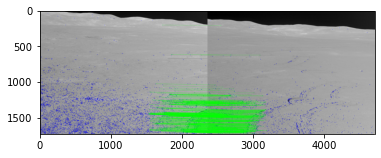

True

In [142]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = (0,0,255),
                   matchesMask = matchesMask, # draw only inliers
                   flags = 0)
img4 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img4, 'gray'),plt.show()
cv.imwrite("img4.png", img4, [cv.IMWRITE_PNG_COMPRESSION, 0])

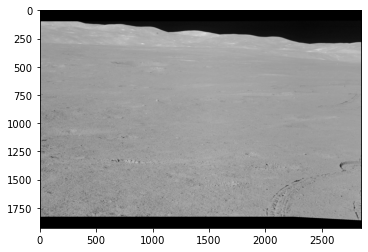

True

In [147]:
top, bot, left, right = 100, 100, 0, 500
srcImg = cv.copyMakeBorder(img1, top, bot, left, right, cv.BORDER_CONSTANT, value=(0, 0, 0))
testImg = cv.copyMakeBorder(img2, top, bot, left, right, cv.BORDER_CONSTANT, value=(0, 0, 0))
rows, cols = srcImg.shape[:2]
warpImg = cv.warpPerspective(testImg, np.array(M), (testImg.shape[1], testImg.shape[0]), flags=cv.WARP_INVERSE_MAP)
for col in range(0, cols):
    if srcImg[:, col].any() and warpImg[:, col].any():
        left = col
        break
for col in range(cols-1, 0, -1):
    if srcImg[:, col].any() and warpImg[:, col].any():
        right = col
        break
res = np.zeros([rows, cols, 3], np.uint8)
for row in range(0, rows):
    for col in range(0, cols):
        if not srcImg[row, col].any():
            res[row, col] = warpImg[row, col]
        elif not warpImg[row, col].any():
            res[row, col] = srcImg[row, col]
        else:
            srcImgLen = float(abs(col - left))
            testImgLen = float(abs(col - right))
            alpha = srcImgLen / (srcImgLen + testImgLen)
            res[row, col] = np.clip(srcImg[row, col] * (1-alpha) + warpImg[row, col] * alpha, 0, 255)
# opencv is bgr, matplotlib is rgb
res = cv.cvtColor(res, cv.COLOR_BGR2RGB)
# show the result
plt.figure()
plt.imshow(res)
plt.show()
cv.imwrite("result.png", res, [cv.IMWRITE_PNG_COMPRESSION, 0])

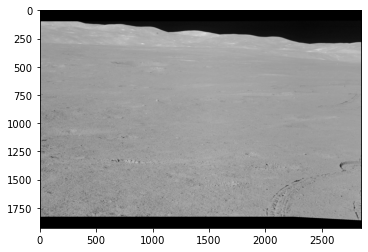

In [144]:
rows, cols = srcImg.shape[:2]
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    warpImg = cv.warpPerspective(testImg, np.array(M), (testImg.shape[1], testImg.shape[0]), flags=cv.WARP_INVERSE_MAP)

    for col in range(0, cols):
        if srcImg[:, col].any() and warpImg[:, col].any():
            left = col
            break
    for col in range(cols-1, 0, -1):
        if srcImg[:, col].any() and warpImg[:, col].any():
            right = col
            break

    res = np.zeros([rows, cols, 3], np.uint8)
    for row in range(0, rows):
        for col in range(0, cols):
            if not srcImg[row, col].any():
                res[row, col] = warpImg[row, col]
            elif not warpImg[row, col].any():
                res[row, col] = srcImg[row, col]
            else:
                srcImgLen = float(abs(col - left))
                testImgLen = float(abs(col - right))
                alpha = srcImgLen / (srcImgLen + testImgLen)
                res[row, col] = np.clip(srcImg[row, col] * (1-alpha) + warpImg[row, col] * alpha, 0, 255)

    # opencv is bgr, matplotlib is rgb
    res = cv.cvtColor(res, cv.COLOR_BGR2RGB)
    # show the result
    plt.figure()
    plt.imshow(res)
    plt.show()
else:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None

In [146]:
cv.imwrite("result.png", res, [cv.IMWRITE_PNG_COMPRESSION, 0])

True

## 整合成函数

In [151]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10

def merge(img_filename1, img_filename2):
    # 读入两张待匹配图片
    img1 = cv.imread(img_filename1,0)
    img2 = cv.imread(img_filename2,0)

    # 初始化SIFT探测器
    sift = cv.SIFT_create()
    
    # 用SIFT算法找出关键点及其信息
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    # 用Lowe算法筛取优质匹配点，0.4表示高精度匹配
    good = []
    for m,n in matches:
        if m.distance < 0.4*n.distance:
            good.append(m)
    
    # 有足够的匹配点后，绘制镶嵌变换
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        #根据镶嵌变换绘制边框
        #h,w,d = img1.shape
        #h,w = img1.shape
        #pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        #dst = cv.perspectiveTransform(pts,M)
        #img3 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    # 将两图联排，绘制匹配和孤立点
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = (0,0,255),
                    matchesMask = matchesMask, # draw only inliers
                    flags = 0)
    img4 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
    plt.imshow(img4, 'gray'),plt.show()
    cv.imwrite("img4.png", img4, [cv.IMWRITE_PNG_COMPRESSION, 0])

    # 根据矩阵进行镶嵌拼合
    top, bot, left, right = 100, 100, 0, 500
    srcImg = cv.copyMakeBorder(img1, top, bot, left, right, cv.BORDER_CONSTANT, value=(0, 0, 0))
    testImg = cv.copyMakeBorder(img2, top, bot, left, right, cv.BORDER_CONSTANT, value=(0, 0, 0))
    rows, cols = srcImg.shape[:2]
    warpImg = cv.warpPerspective(testImg, np.array(M), (testImg.shape[1], testImg.shape[0]), flags=cv.WARP_INVERSE_MAP)
    for col in range(0, cols):
        if srcImg[:, col].any() and warpImg[:, col].any():
            left = col
            break
    for col in range(cols-1, 0, -1):
        if srcImg[:, col].any() and warpImg[:, col].any():
            right = col
            break
    res = np.zeros([rows, cols, 3], np.uint8)
    for row in range(0, rows):
        for col in range(0, cols):
            if not srcImg[row, col].any():
                res[row, col] = warpImg[row, col]
            elif not warpImg[row, col].any():
                res[row, col] = srcImg[row, col]
            else:
                srcImgLen = float(abs(col - left))
                testImgLen = float(abs(col - right))
                alpha = srcImgLen / (srcImgLen + testImgLen)
                res[row, col] = np.clip(srcImg[row, col] * (1-alpha) + warpImg[row, col] * alpha, 0, 255)
    # opencv is bgr, matplotlib is rgb
    res = cv.cvtColor(res, cv.COLOR_BGR2RGB)
    # show the result
    plt.figure()
    plt.imshow(res)
    plt.show()
    cv.imwrite("result.png", res, [cv.IMWRITE_PNG_COMPRESSION, 0])

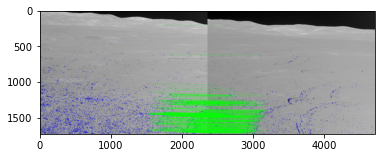

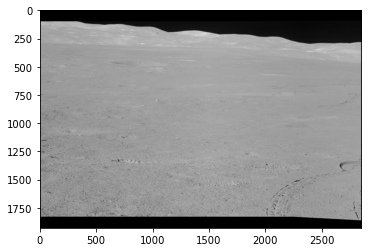

In [149]:
merge('CE4_GRAS_PCAML-C-000_SCI_N_20190708043358_20190708043358_0048_B_1.png', 
      'CE4_GRAS_PCAML-C-001_SCI_N_20190708043517_20190708043517_0048_B_1.png')

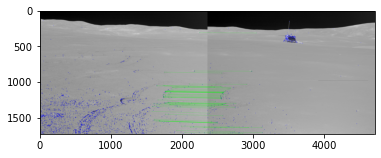

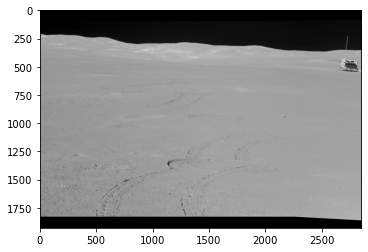

In [153]:
merge('CE4_GRAS_PCAML-C-001_SCI_N_20190708043517_20190708043517_0048_B_1.png', 
      'CE4_GRAS_PCAML-C-002_SCI_N_20190708043636_20190708043636_0048_B_1.png')

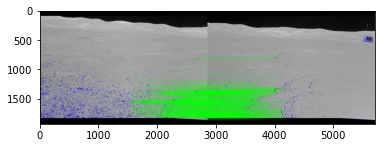

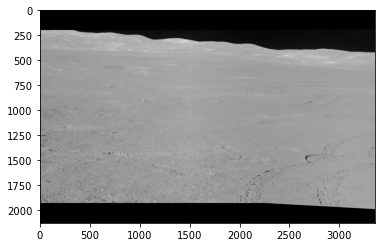

In [154]:
merge('result1.png', 
      'result2.png')